Convex Optimization course

Dr. Yassaee

HW4.Q7

Student name: Seyyed Amirmahdi Sadrzadeh

Student number: 401102015

# Q7. Lasso

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Including Libraries


In [20]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

## **Problem Statement**
We aim to solve the 2D Lasso optimization problem for image denoising:
$$
\min_{\theta \in \mathbb{R}^{m \times n}} \sum_{i=1}^{mn} \frac{1}{2}(y_i - \theta_i)^2 + \lambda \sum_{(i,j)\in E} |\theta_i - \theta_j|
$$
The first term is the fidelity term (minimizes difference between noisy image Y and denoised image $\theta$).

The second term is the total variation (TV) regularization (promotes piecewise smoothness by penalizing differences between neighboring pixels).

And $E$ is the set of edges connecting each pixel to its horizontal and vertical neighbors.

### **Part 1**

1. **Roles of the Two Terms**:
   - **Fidelity Term**: Ensures the denoised image $\theta$ stays close to the noisy input $Y$.
   - **TV Regularization**: Encourages smoothness by penalizing large differences between adjacent pixels. This removes noise while preserving edges.

2. **Convexity**:
   - The problem is **convex** because:
     - The squared error term is convex.
     - The absolute difference term (L1 norm) is convex.
     - Sum of convex functions is convex.

3. **Role of $\lambda$**:
   - **Small $\lambda$**: Prioritizes fidelity to $Y$ → noisy output.
   - **Large $\lambda$**: Prioritizes smoothness → oversmoothing and loss of details.

### **Part 2**

#### **Loading Data**
We load the noisy image data from `toy.csv`, which represents a 2D grid of pixel values. The goal is to denoise this image using the 2D Lasso (Total Variation) formulation.

In [23]:
data = pd.read_csv('/content/drive/MyDrive/Convex/toy.csv', header=None)
Y = data.values
m, n = Y.shape

#### **Solving for λ = 1**
We set `λ = 1` and solve the convex optimization problem using CVXPY. The total variation term will moderately smooth the image while preserving edges.

In [24]:
y = Y.flatten()
theta = cp.Variable(y.shape)

# Total Variation (TV) regularization term
def tv_term(theta, m, n):
    theta_mat = cp.reshape(theta, (m, n))
    horizontal_diff = cp.sum(cp.abs(theta_mat[:, 1:] - theta_mat[:, :-1]))
    vertical_diff = cp.sum(cp.abs(theta_mat[1:, :] - theta_mat[:-1, :]))
    return horizontal_diff + vertical_diff

lambda_val = 1.0

# Build and solve the problem
objective = cp.Minimize(0.5 * cp.sum_squares(y - theta) + lambda_val * tv_term(theta, m, n))
problem = cp.Problem(objective)
problem.solve()

/usr/local/lib/python3.11/dist-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


np.float64(233.33396935721197)

#### **Objective Function Value**
The objective value quantifies the trade-off between fidelity to the noisy data and smoothness. A lower value indicates a better balance. The value we achieved:

In [25]:
print("Objective value:", problem.value)

Objective value: 233.33396935721197


#### **Visualization**
We plot the original noisy data and the denoised result side-by-side. For `λ = 1`:

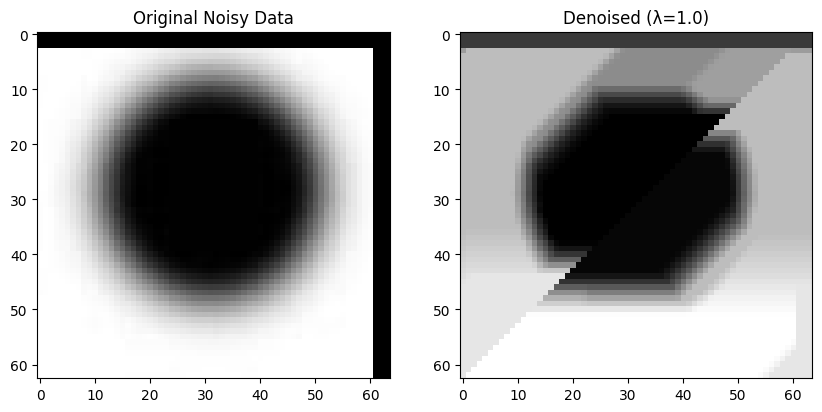

In [26]:
denoised_image = theta.value.reshape((m, n))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(Y, cmap='gray')
plt.title("Original Noisy Data")

plt.subplot(122)
plt.imshow(denoised_image, cmap='gray')
plt.title(f"Denoised (λ={lambda_val})")

plt.show()

We can see that the noise has decreased a little and the edges of the image are blurred so the image isn't satisfying and it is better to increase $\lambda$.

### **Part 3**

#### **Solving for Isotropic TV**
We solve the optimization problem with isotropic TV regularization for `λ = 1`:

In [27]:
def tv_isotropic_term(theta, m, n):
    """
    Computes isotropic TV regularization using L2 norm of gradient pairs.
    """
    theta_mat = cp.reshape(theta, (m, n))

    # Horizontal differences (shape: (m, n-1))
    diff_h = theta_mat[:, 1:] - theta_mat[:, :-1]

    # Vertical differences (shape: (m-1, n))
    diff_v = theta_mat[1:, :] - theta_mat[:-1, :]

    # Truncate to overlapping regions (shape: (m-1, n-1))
    diff_h_trunc = diff_h[:-1, :]
    diff_v_trunc = diff_v[:, :-1]

    # Stack differences into pairs and compute L2 norm
    diff_pairs = cp.hstack([cp.vec(diff_h_trunc), cp.vec(diff_v_trunc)])
    diff_pairs = cp.reshape(diff_pairs, (diff_h_trunc.size, 2))
    norms = cp.norm(diff_pairs, p=2, axis=1)

    return cp.sum(norms)

lambda_val = 1.0
objective_isotropic = cp.Minimize(0.5 * cp.sum_squares(y - theta) + lambda_val * tv_isotropic_term(theta, m, n))
problem_isotropic = cp.Problem(objective_isotropic)
problem_isotropic.solve()

# Get denoised image
denoised_isotropic = theta.value.reshape((m, n))

/usr/local/lib/python3.11/dist-packages/cvxpy/atoms/affine/vec.py:40: FutureWarning: 
    You didn't specify the order of the vec expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(vec_order_warning, FutureWarning)


In [30]:
def tv_anisotropic_term(theta, m, n):
    theta_mat = cp.reshape(theta, (m, n))
    horizontal_diff = cp.sum(cp.abs(theta_mat[:, 1:] - theta_mat[:, :-1]))
    vertical_diff = cp.sum(cp.abs(theta_mat[1:, :] - theta_mat[:-1, :]))
    return horizontal_diff + vertical_diff

objective_anisotropic = cp.Minimize(0.5 * cp.sum_squares(y - theta) + lambda_val * tv_anisotropic_term(theta, m, n))
problem_anisotropic = cp.Problem(objective_anisotropic)
problem_anisotropic.solve()
denoised_anisotropic = theta.value.reshape((m, n))

#### **Visualization**

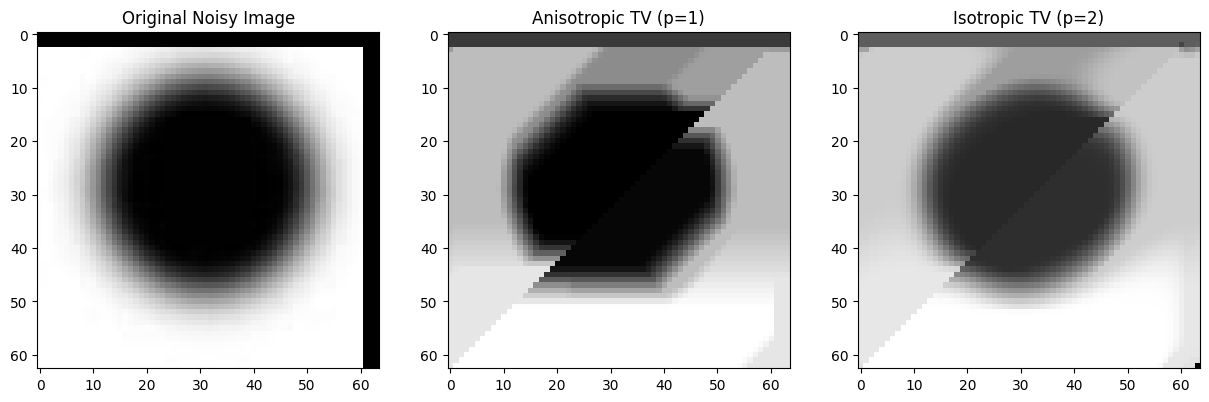

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(Y, cmap='gray')
plt.title("Original Noisy Image")

plt.subplot(132)
plt.imshow(denoised_anisotropic, cmap='gray')
plt.title("Anisotropic TV (p=1)")

plt.subplot(133)
plt.imshow(denoised_isotropic, cmap='gray')
plt.title("Isotropic TV (p=2)")

plt.show()

#### **Comparison of Anisotropic vs. Isotropic TV**

We can see that the results for the isotropic with p=2 is much better than the previous one.

 **Why the Difference?**:
   - Isotropic TV treats the gradient as a vector, promoting natural edge structures.
   - Anisotropic TV penalizes each axis separately, leading to axis-aligned bias.

In [32]:
print("Anisotropic Objective:", problem_anisotropic.value)
print("Isotropic Objective:", problem_isotropic.value)

Anisotropic Objective: 233.33396935721197
Isotropic Objective: 214.20751759950048
